<a href="https://colab.research.google.com/github/CFA-Institute-RPC/Synthetic-Data-For-Finance/blob/main/LLM/02-Qwen3_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Qwen3 for improved sentiment analysis of financial texts

In this notebook, we fine-tune a small large language model (LLM), Qwen3-0.6B,
to perform sentiment analysis on financial texts from the FiQA-SA dataset.

We use the training samples to fine-tune the model and evaluate its performance on the validation dataset.

In the third notebook, we will generate some synthetic data using OpenAI's ChatGPT-4o model which we will use to augment our training data.

In the fourth notebook, we will fine-tune a second Qwen3-0.6B model on this augmented dataset, containing both real and synthetic data, to see if we can improve the model's performance on the validation dataset.

In summary, we compare two models.
* Model 1: A fine-tuned Qwen3 model using **real data** from the FIQA-SA training dataset
* Model 2: A fine-tuned Qwen3 model using **real + synthetic data** from FIQA-SA and synthetically generated data produced by a GPT4-o.

# Installation


We first install the required packages.
* Unsloth - a lightweight Python library enabling fast LLM fine-tuning
* accelerate - a Hugging Face library, provides functions to optimize LLM usage on GPUs, TPUs and others to speed up training/inference.
* trl - Transformer reinforcement learning - library for training LLMs
* peft - Parameter-Efficient Fine-Tuning library developed by Hugging Face. It is used to efficiently fine-tune LLMs to adapt them to downstream tasks without re-training all the weights of the LLM.

In [ ]:
!pip install --no-deps bitsandbytes==0.45.5 accelerate==1.6.0 xformers==0.0.29.post3 peft==0.15.2 trl==0.15.2 triton==3.2.0 cut_cross_entropy==25.1.1
!pip install --no-deps git+https://github.com/mmathew23/unsloth-zoo.git@t4mixed
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth==2025.5.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.7.0
    Uninstalling accelerate-1.7.0:
      Successfully uninstalled accelerate-1.7.0
  Cloning https://github.com/mmathew23/unsloth-zoo.git (to revision t4mixed) to /tmp/pip-req-build-ouqskez1
  Running command git clone --filter=blob:none --quiet https://github.com/mmathew23/unsloth-zoo.git /tmp/pip-req-build-ouqskez1
  Running command git checkout -b t4mixed --track origin/t4mixed
  Switched to a new branch 't4mixed'
  Branch 't4mixed' set up to track remote branch 't4mixed' from 'origin'.
  Resolved https://github.com/mmathew23/unsloth-zoo.git to commit a05a9a46013a46f1d9ff90f8d47db2cb6b

In [ ]:
#!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
#!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
#!pip install --no-deps unsloth

# Import libraries


In [ ]:
# Import libraries
import torch
major_version, minor_version = torch.cuda.get_device_capability() # Outputs GPU compute capability version (major) and indicator (minor)
print(f"Major: {major_version}, Minor: {minor_version}")
import pandas as pd
import numpy as np
from datascience import *
import os
import warnings
import matplotlib.pyplot as plt
import random
from tqdm import tqdm # Add progress bar to for loops
from unsloth import FastLanguageModel
from unsloth import tokenizer_utils
from transformers import AutoTokenizer, Qwen3ForSequenceClassification
import torch.nn.functional as F



Major: 7, Minor: 5
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# In order to speed up fine-tuning, we trim the size of the classification head to contain only the number tokens (1, 2 etc) which reduces memory usage.
# The function below doesn't work if we alter the classification head of the model in this way - so we overwrite this function to not do anything
def do_nothing(*args, **kwargs):
  pass

tokenizer_utils.fix_untrained_tokens = do_nothing

# Loading the model and tokenizer

We now load the 0.6B parameter Qwen3 model, alongside its default tokenizer. A tokenizer is used to convert input sentences into numerical embeddings that can be fed into an LLM. Different models are trained using different tokenizers.

In [ ]:
# Load model
model_name = "unsloth/Qwen3-0.6B-Base";load_in_4bit = False # load_in_4bit controls whether to use 4-bit quantization for model weights to speed up training

# Number of sentiment classes
NUM_CLASSES = 3

# Defines the max no. of tokens in an input sentence. Unsloth uses RoPE scaling internally which means it doesn't matter if the LLM sees an input that is longer than this, so any number is fine. We stick with the default 2048.
max_seq_length = 2048

dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+

# Load LLM and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

# Optimizing model fine-tuning
Fine-tuning a LLM takes a lot of time and computational resources, even for a 'small' LLM such as the 0.6B parameter Qwen3 model. In the section below we introduce a few tricks courtesy of the `Unsloth` library we installed to more efficiently fine-tune the model.

## Trimming the classification head

Our loaded Qwen3 LLM is the base LLM that was pre-trained on a vocabulary size of 151,936 tokens, learning to best predict the probability of each token for a particular input. Fine-tuning our model to predict all of these tokens is a waste of our time as we are only interested in predicting the tokens corresponding to the sentiment labels 1,2 and 3. To address this, we 'trim' the classification head.

However, we first need to find out how these labels are represented in our pre-trained tokenizer, which is used to convert each word in an input sentence into tokenized, numerical representations that can be fed as input to an LLM.

In the code below we trim the classification head so the model is only trained to predict the tokens 0-NUM_CLASSES (we don't use 0 here but it is kept for simplicity).

In [ ]:
# Trim the classification head so the model can only output numbers 0-NUM_classes (0 is kept to make everything simpler)
number_token_ids = []

# Find and store the tokenizer-encoded representations of each label class (0,1,2,3) (we don't use 0 as a class label but we keep it for simplicity)
for i in range(0, NUM_CLASSES+1):
  number_token_ids.append(tokenizer.encode(str(i), add_special_tokens=False)[0])
  # Keep only the number tokens from lm_head

# Keep only the weights corresponding to prediction of our class labels - we will train these weights during the fine-tuning process.
par = torch.nn.Parameter(model.lm_head.weight[number_token_ids,:])

old_shape = model.lm_head.weight.shape
old_size = old_shape[0]
print('The old size of the classification head was:', old_shape)
print('The new size of the classification head is:', par.shape)

#Modify the shape of the classification head to par
model.lm_head.weight = par

reverse_map = {value: idx for idx, value in enumerate(number_token_ids)} # Used later to convert the tokenizer-encoded class labels to the new classification head
reverse_map


The old size of the classification head was: torch.Size([151936, 1024])
The new size of the classification head is: torch.Size([4, 1024])


{15: 0, 16: 1, 17: 2, 18: 3}

We see the old lm head had 151,936 outputs, one for each token (1024 is the number of nodes in the final layer). Thus, we have significantly reduced the number of trainable weights by trimming the classification head. We can also see the tokenizer-encoded values of the class labels during model pre-training were 15, 16, 17 and 18 for the strings 0, 1, 2, 3.

## QLoRA and parameter-efficient fine-tuning


In the code below, we use QLoRA to compress the weights of the target_model layers into 4-bit quantized form. These weights are then frozen and a small number of trainable parameters are added in the form of Low-Rank Adapters (LoRA). The number of low-rank adaptors in each layer is determined by `lora_alpha`. The LoRA layers are the only layers that are updated during fine-tuning.

In [ ]:
from peft import LoftQConfig

# Set up QLoRA for model
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # rank of the low-rank matrices (A and B) used to approximate  weight updates during fine-tuning
    target_modules = [
        'lm_head',
        'q_proj', 'k_proj','v_proj','o_proj',
        'gate_proj', 'up_proj', 'down_proj'], # Specify the layers that you want to fine-tune
    lora_alpha = 16, # Represents a constant, each AB matrix is scaled by (lora_alpha / r). This is another hyperparameter to be optimized, but is conventionally set to r such that the matrix is scaled by 1.
    lora_dropout = 0, # Can change to any value from 0-1 but 0 is optimized - represents how many of the trained matrices to drop-out
    bias='none', # Whether to include bias terms to train - 'none' is optimized
    use_gradient_checkpointing = 'unsloth',
    random_state=42, # Set for reproducibility in re-initializing the values in the low-rank matrices
    use_rslora = True,

)
# Count number of trainable parameters
print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.5.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM
Trainable parameters: 10096640


## Loading the data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
train = pd.read_csv('drive/MyDrive/data/train.csv')

train = train[['sentence','label']]

In [ ]:
train['label'].value_counts()

,count
label,
3,546
1,264
2,12


Label 3 represents positive sentiment, label 1 represents negative sentiment, and label 2 represents neutral sentiment.

In [ ]:

# Create prompt for the Qwen3 model
prompt = """Here is a sentence related to a company:
{}

Classify the sentiment into one of the following:
class 1: Negative
class 2: Neutral
class 3: Positive

SOLUTION
The correct answer is: class {}"""


# This function takes a dataset as input, and for each row in the dataset, formats it into an LLM prompt such that the first {} is filled with the sentence and the second {} is the label.
def formatting_prompts_func(dataset_):
  sentences = []
  for i in range(len(dataset_['sentence'])):
    sentence_ = dataset_['sentence'].iloc[i]
    label_ = dataset_['label'].iloc[i]

    sentence = prompt.format(sentence_, label_)

    sentences.append(sentence)
  return sentences

# Apply formatting_prompts_func to the sentence row in the training dataset
train['sentence'] = formatting_prompts_func(train)

train.head()


,sentence,label
0,Here is a sentence related to a company:\nRoya...,1
1,Here is a sentence related to a company:\nSlum...,1
2,Here is a sentence related to a company:\nAstr...,3
3,Here is a sentence related to a company:\nUPDA...,1
4,Here is a sentence related to a company:\nStan...,1


In [ ]:
# Convert pd dataframe into HuggingFace dataset optimized for LLMs
import datasets
train_dataset = datasets.Dataset.from_pandas(train, preserve_index=False)

The `DataCollatorForLanguageModeling`is a data collator class that alters the input of a sentence for LLM modeling. It pads the input of each input sentence to the maximum length of a batch and also randomly masks tokens used to train the LLM. However, for our use case we only want to train the LLM on the last token of each sentence. In the code below we create a custom data collator that inherits from the `DataCollatorForLanguageModeling` class and modifies it for this purpose.

In [ ]:
from transformers import DataCollatorForLanguageModeling
from typing import List, Dict, Union, Any
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
  def __init__(
      self,
      *args,
      mlm: bool = False, # Disable masked language modeling (mlm)
      ignore_index: int = -100, # Used to specify label indices to be ignored using the calculation of cross-entropy loss (e.g if we don't care about class label 0, we set ignore_index=0)
      **kwargs,
  ):

    super().__init__(*args, mlm=mlm, **kwargs) # Call the parent class (DataCollatorForLanguageModeling  and set mlm=False)
    self.ignore_index = ignore_index # Set the ignore_index value in the parent class

  def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
    batch = super().torch_call(examples) # Define the batch of training examples

    for i in range(len(examples)):
      # For each batch of examples, get the labels we're interested in predicting, get the pytorch tensor using .nonzero(), get the last row using [-1]
      last_token_idx = (batch['labels'][i] != self.ignore_index).nonzero()[-1].item()
      # Set all labels to ignore_index except for the last token
      batch['labels'][i, :last_token_idx] = self.ignore_index

      # If the last token in the sentence is 0,1,2, or 3, this was processed with the old tokenizer as number_token_ids[1], number_token_ids[2] etc.
      # However, these indexes don't exist in the new classification head, so we map the indexes to the new lm_head index instead
      batch['labels'][i, last_token_idx] = reverse_map[ batch['labels'][i, last_token_idx].item() ]

    return batch

  # Instantiate an instance of the custom collator which maps the old tokenizer to the new tokenizer
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

## Training the model
We now use the TRL library's `SFTTrainer` which can be used to perform supervised fine-tuning of a LLM.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 1, # Number of workers used to tokenize the data
    packing = False, # Whether to group shorter sentences together into a larger sentence - we set to False as we already
    args = TrainingArguments( # Define training arguments
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        #logging_step = 1,
        optim = 'adamw_8bit',
        weight_decay = 0.01,
        lr_scheduler_type = 'cosine',
        seed = 42,
        output_dir = 'outputs',
        num_train_epochs = 3, # 3 is the default, more epochs can improve performance.
        report_to = 'none',
        group_by_length = True
    ),
    data_collator = collator,
    dataset_text_field='sentence'
)

Unsloth: Tokenizing ["sentence"]:   0%|          | 0/822 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 822 | Num Epochs = 3 | Total steps = 78
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss


## Evaluating model performance
Now that the model has been trained, we can evaluate its performance on the validation dataset.

In [ ]:
FastLanguageModel.for_inference(model) # Speeds up inference
print()

## Restructuring the language modeling head for improved compatibility with other libraries
The code below restructures the language modeling head back to its original size, in theory allowing it to output any token that Qwen3 was pre-trained on. However, we set the weights of all unused tokens (i.e, any token except 0, 1,2,3) to 0 and add -1000 bias. This means the model is still only able to output labels 0,1,2 as the predicted probability of all other output tokens are 0.

In [ ]:
# Save optimized weights and biases of current trimmed language model head
trimmed_lm_head = model.lm_head.weight.data.clone() # Clone the weights
trimmed_lm_head_bias = model.lm_head.bias.data.clone()if hasattr(model.lm_head, "bias") and model.lm_head.bias is not None else torch.zeros(len(number_token_ids), device=trimmed_lm_head.device) # Save biases if present, otherwise, save biases as 0

# Re-construct the old language model head with the old shape
hidden_dim = trimmed_lm_head.shape[1]
new_lm_head = torch.full((old_size,hidden_dim),0, dtype=trimmed_lm_head.dtype, device=trimmed_lm_head.device) # Create torch tensor of 0 weights with shape [old_size, hidden_dim]
new_lm_head_bias = torch.full((old_size,), -1000.0, dtype=trimmed_lm_head_bias.dtype, device=trimmed_lm_head_bias.device)

# Fill in the trained weights and biases for the allowed tokens representing the classification labels (number_token_ids)
for new_idx, orig_token_id in enumerate(number_token_ids):
  new_lm_head[orig_token_id] = trimmed_lm_head[new_idx]
  new_lm_head_bias[orig_token_id] = trimmed_lm_head_bias[new_idx]

# Update the model's language model head weights and biases
with torch.no_grad():
  new_lm_head_module = torch.nn.Linear(hidden_dim, old_size, bias=True, device=model.device)
  new_lm_head_module.weight.data.copy_(new_lm_head)
  new_lm_head_module.bias.data.copy_(new_lm_head_bias)
  model.lm_head.modules_to_save['default'] = new_lm_head_module


In [ ]:
print(f'Re-constructed language model head shape = {model.lm_head.weight.shape}. Allowed tokens: {number_token_ids}')

Re-constructed language model head shape = torch.Size([151936, 1024]). Allowed tokens: [15, 16, 17, 18]


## Inference time!

In [ ]:
# Load validation data and view first few rows
val = pd.read_csv('drive/MyDrive/data/val.csv')

val = val[['sentence','label']]
val.head()
val['label'].value_counts()

,count
label,
3,70
1,47


We see the validation data has no neutral labels (2) here, so we can't assess how the LLM performs on the minority class.

In [ ]:
# Prepare inference prompt
inference_prompt_template = prompt.split('class {}')[0] + 'class '

# Sort validation data by length for efficient batch processing
val['token_length'] = val['sentence'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
val_sorted = val.sort_values(by='token_length').reset_index(drop=True)

from sklearn.metrics import f1_score, classification_report
batch_size = 16 # Define batch_size
device = model.device
correct = 0 # Start counter of correct classifications

y_pred = []
y_true = []
with torch.inference_mode():
  for i in tqdm(range(0, len(val_sorted), batch_size), desc='Evaluating'):
    batch = val_sorted.iloc[i:i+batch_size] # Get the current batch
    prompts = [inference_prompt_template.format(text) for text in batch['sentence']] # Format each sentence into inference prompt template
    inputs = tokenizer(prompts, return_tensors ='pt', padding=True, truncation=True, max_length=max_seq_length).to(device) # Tokenize the input prompts
    logits = model(**inputs).logits # Get the logits (output from the model from last hidden layer)
    last_idxs = inputs.attention_mask.sum(1) -1 # attention_mask is a binary tensor containing the positions of tokens in each prompt that don't need to be attended to, e.g padding tokens used to standardize the prompt length, a value of 1 in the tensor is used to represent attended tokens. Here, we get the index of each attended token in each sentence in the attention_mask tensor and extract the index of the last attended token
    last_logits = logits[torch.arange(len(batch)), last_idxs, :] # Get the logits of the final token for each
    probs_all = F.softmax(last_logits, dim=-1) # Apply softmax function to final logits to convert logits into probabilities
    probs = probs_all[:, number_token_ids] # Only keep probabilities for the number tokens
    preds = torch.argmax(probs, dim=-1).cpu().numpy() # Predictions - shape is [1 1 2 3 1 2 3 ... ]

    y_pred.extend(preds.tolist()) # Append predicted labels to list
    y_true.extend(batch['label'].tolist()) # Append true labels to list

    true_labels = batch['label'].tolist() # Get true labels
    correct += sum([p == t for p, t in zip(preds, true_labels)]) # Calculate how many labels are correct for each batch

overall_accuracy = 100 * correct / len(val_sorted)
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"\nValidation accuracy (Overall): {overall_accuracy:.2f}% ({correct}/{len(val_sorted)})")
print(f"\nValidation weighted F1-score: {f1_weighted:.4f}")



Evaluating: 100%|██████████| 8/8 [00:01<00:00,  6.70it/s]


Validation accuracy (Overall): 75.21% (88/117)

Validation weighted F1-score: 0.7529


We see the accuracy and weighted F1-score on the validation set is 75.21% and 75.29% respectively.

Let's take a look at the confusion matrix, this tells us how well the model performed at classifying each class.

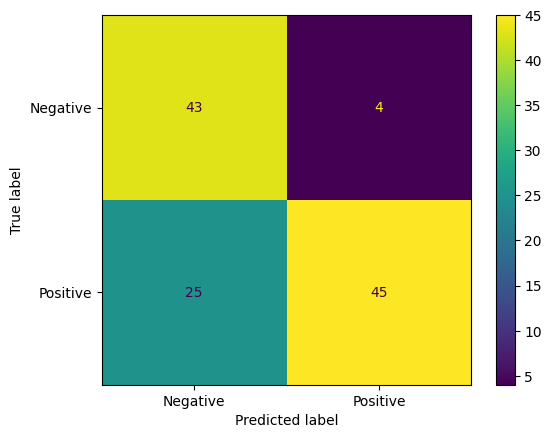

In [ ]:
# Confusion matrix
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path

Path('/content/drive/MyDrive/results/').mkdir(parents=True, exist_ok=True)

cm = confusion_matrix(y_true,y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=['Negative','Positive'])
disp.plot()
plt.savefig('drive/MyDrive/results/model_1_results.svg')
plt.show()

The model classifies almost all of the '1' labels correctly, but misclassifies a lot of the '3' (positive sentiment) labels. There's clearly some room for improvement.

One option could be using synthetic data - we'll do that in the next notebook and see if we can improve upon these performance metrics.
